# Computer Vision and Convolutionary Neural Networks

## 0. Computer vision libraries
* "torchvision" base domain library for PyTorch computer vision
* "torchvision.datasets" datasets and data loading functions for computer vision
* "torchvision.models" pretrained models for computer vision models
* "torchvision.transforms" fuctions for manipulating vision data
* "torchvision.utils.data.Dataset" base dataset class for pytorch
* "torch.utils.data.DataLoader" creates a python iterable over a dataset

In [36]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchmetrics.classification import F1Score
from torchmetrics.classification import Accuracy
from torchmetrics.classification import ConfusionMatrix

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from timeit import default_timer as timer
from tqdm.auto import tqdm
from mlxtend.plotting import plot_confusion_matrix
from pathlib import Path



print(torch.__version__)
print(torchvision.__version__)

2.4.1+cu124
0.19.1+cu124


In [3]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
device

'cuda'

## 1. Dataset

In [4]:
train_data = datasets.FashionMNIST(
    root="data",  # where to download data to
    train=True,  # should we get the training dataset, otherwise testing data is downloaded
    download=True,  # if we want to download it
    transform=ToTensor(),  # HOW DO WE WANT TO TRANSFORM THE DATA
    target_transform=None,  # transforming the labels
)

test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor(), target_transform=None
)

In [5]:
len(train_data), len(test_data)

(60000, 10000)

In [6]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [8]:
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

### 1.2 Visualizing data

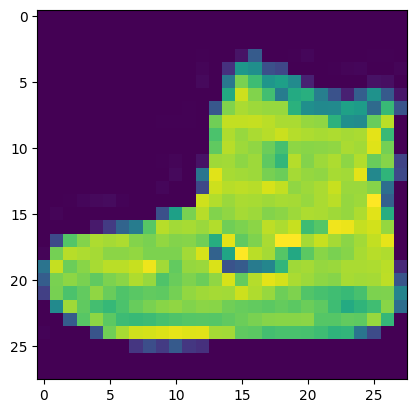

In [9]:
plt.imshow(image[0])
plt.show()

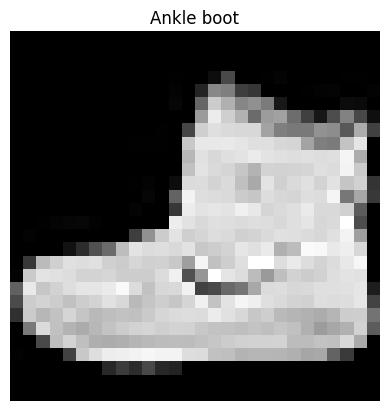

In [10]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
plt.show()

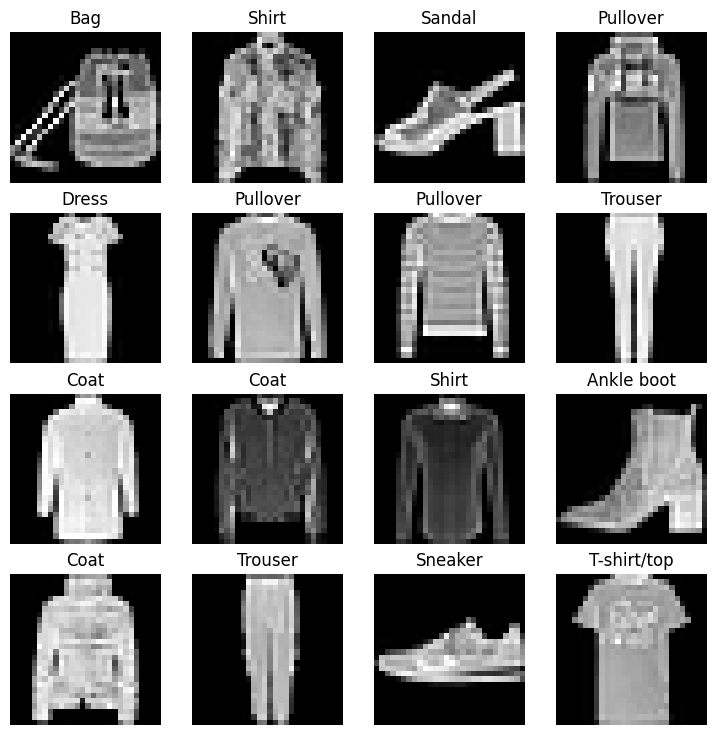

In [11]:
torch.manual_seed = 42
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(rows * cols):
    random_index = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_index]
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## 2. Prepara dataloader

In [12]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

# 3. Model
### 3.0 linear model

When starting to build a series of machine learning modelling experiments, it's good practice to start with a baseline model.

Baseline model is a simple model, that will be improved over subsequent experiments.

In [13]:
class FashionMnistModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )

    def forward(self, x):
        return self.layers(x)


torch.manual_seed = 42
model_0 = FashionMnistModelV0(input_shape=(28 * 28), hidden_units=512, output_shape=10)
model_0 = model_0.to(device)
model_0, next(model_0.parameters()).is_cuda

(FashionMnistModelV0(
   (layers): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=512, bias=True)
     (2): Linear(in_features=512, out_features=10, bias=True)
   )
 ),
 True)

### 3.1 setting up optimizer, loss and classification metric

In [14]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.03)
metric = F1Score(task="multiclass", num_classes=10).to(device)

### 3.2 Creating a function to time experiments

In [15]:
def print_train_time(start: float, end: float, device: torch.device = None):
    print("nothing")
    """Prints diffrence between start and end time."""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [16]:
start_time = timer()
end_time = timer()
print_train_time(start_time, end_time, device="cpu")

nothing
Train time on cpu: 0.000 seconds


1.5046000044094399e-05

### 3.3 creating a training lool and training model on batches of data

In [17]:
# epochs = 1

# for epoch in range(epochs):
#     for data, labels in train_dataloader:
#         model_0.train()
#         data = data.to(device)
#         labels = labels.to(device)

#         # training
#         logits = model_0(data)
#         loss = loss_fn(logits, labels)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     # evaluation
#     if epoch % 1 == 0:
#         model_0.eval()
#         with torch.inference_mode():
#             avg_test_loss = 0
#             avg_test_F1Score = 0

#             for data, labels in test_dataloader:
#                 data = data.to(device)
#                 labels = labels.to(device)

#                 test_logits = model_0(data)
#                 avg_test_loss += loss_fn(test_logits, labels)
#                 predictions = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
#                 avg_test_F1Score += metric(preds=predictions, target=labels)

#             avg_test_loss = avg_test_loss / len(test_dataloader)
#             avg_test_F1Score = avg_test_F1Score / len(test_dataloader)
#             print(
#                 f"epoch: {epoch} | F1Score: {avg_test_F1Score} | loss: {avg_test_loss}"
#             )

# 4 Evaluate model

In [18]:
def eval_model(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    eval_fn,
):
    """Returns a dictionary of results of model evaluation"""
    model = model.to(device)
    model.eval()
    with torch.inference_mode():
        score = 0
        loss = 0
        loops = 0

        for X, y in data_loader:
            loops += 1
            X = X.to(device)
            y = y.to(device)

            logits = model(X)
            loss += loss_fn(logits, y)
            predictions = torch.argmax(torch.softmax(logits, dim=1), dim=1)
            score += eval_fn(preds=predictions, target=y).item()

        if loops == 0:
            return None
        score = score / loops
        loss = loss / loops
        name = model.__class__.__name__
        return {"model": name, "score": score, "loss": loss.item()}

In [19]:
# results = eval_model(
#     model=model_0, data_loader=train_dataloader, loss_fn=loss_fn, eval_fn=metric
# )
# results

# 5. Building a nonlinear model

### 5.1 Creating a model

In [20]:
class FashionMnistModelV1(nn.Module):
    def __init__(self, in_features: int, hidden_units: int, out_features: int):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_features),
        )

    def forward(self, x):
        return self.layers(x)


model_1 = FashionMnistModelV1(
    in_features=(28 * 28), hidden_units=512, out_features=10
).to(device)
model_1, next(model_1.parameters()).device

(FashionMnistModelV1(
   (layers): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=512, bias=True)
     (2): ReLU()
     (3): Linear(in_features=512, out_features=512, bias=True)
     (4): ReLU()
     (5): Linear(in_features=512, out_features=10, bias=True)
   )
 ),
 device(type='cuda', index=0))

### 5.2 Defining loss, optimizer and evaluation

In [21]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer_1 = torch.optim.SGD(params=model_1.parameters(), lr=0.01)
eval_fn = F1Score(task="multiclass", num_classes=10).to(device)

### 5.3 Training and testing

In [22]:
def train_step(
    model: nn.Module, loss_fn: nn.Module, optimizer, train_dataloader: DataLoader
):
    avg_loss = 0

    model.to(device)
    model.train()

    for data, labels in train_dataloader:
        data = data.to(device)
        labels = labels.to(device)

        # training
        logits = model(data)
        loss = loss_fn(logits, labels)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if len(train_dataloader) == 0:
        return None
    avg_loss = avg_loss / len(train_dataloader)
    return avg_loss

In [23]:
def test_step(
    model: nn.Module, loss_fn: nn.Module, eval_fn, test_dataloader: DataLoader
):
    model.to(device)
    model.eval()
    with torch.inference_mode():
        avg_loss = 0
        avg_eval = 0

        for data, labels in test_dataloader:
            data = data.to(device)
            labels = labels.to(device)

            test_logits = model(data)
            test_loss = loss_fn(test_logits, labels)
            avg_loss += test_loss.item()
            predictions = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
            avg_eval += eval_fn(preds=predictions, target=labels).item()

        if len(test_dataloader) == 0:
            return None

        avg_loss = avg_loss / len(test_dataloader)
        avg_eval = avg_eval / len(test_dataloader)

        return (avg_loss, avg_eval)

In [24]:
# epochs = 10

# for epoch in tqdm(range(epochs)):
#     train_loss = train_step(model_1, loss_fn, optimizer_1, train_dataloader)
    
#     if epoch % 4 == 0:
#         test_loss, test_score = test_step(model_1, loss_fn, eval_fn, test_dataloader)
#         print(f"training loss: {train_loss} | testing loss: { test_loss} | testing F1Score: {test_score}")

### 5.4 Evaluation

In [25]:
# evaluation = eval_model(
#     model=model_1, data_loader=test_dataloader, loss_fn=loss_fn, eval_fn=eval_fn
# )
# evaluation

# 6. Convolutional neural network

In [26]:
class FashionMnistModelV2(nn.Module):
    def __init__(
        self,
        channels: int,
        no_of_feature_maps:int,
        height:int,
        width:int,
        hidden_units_0: int,
        hidden_units_1: int,
        output_shape: int,
    ):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, no_of_feature_maps, kernel_size=5, stride=1, padding=2),
            nn.AvgPool2d(kernel_size=3, stride = 2, padding = 1),
        )

        pooling_output_size = 12544
        
        self.deep_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(pooling_output_size, hidden_units_0),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_units_0, hidden_units_1),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_units_1, output_shape),
        )       

    def forward(self, x):
        return self.deep_layers(self.conv_layers(x))

model_2 = FashionMnistModelV2(
    channels=1, no_of_feature_maps=64, height=28, width=28, hidden_units_0=1024, hidden_units_1=256, output_shape=10
).to(device)

In [27]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer_2 = torch.optim.SGD(params=model_2.parameters(), lr=0.01)
eval_fn = F1Score(task="multiclass", num_classes=10).to(device)

In [28]:
evaluation = eval_model(
    model=model_2, data_loader=test_dataloader, loss_fn=loss_fn, eval_fn=eval_fn
)
evaluation

{'model': 'FashionMnistModelV2',
 'score': 0.10283546325878594,
 'loss': 2.3067290782928467}

In [29]:
epochs = 30
time_begin = timer()

for epoch in tqdm(range(epochs)):
    train_loss = train_step(model_2, loss_fn, optimizer_2, train_dataloader)
    
    if epoch % 4 == 0:
        test_loss, test_score = test_step(model_2, loss_fn, eval_fn, test_dataloader)
        print(f"training loss: {train_loss} | testing loss: { test_loss} | testing F1Score: {test_score}")

time_end = timer()
tme_elapsed = time_end - time_begin

minutes = int(tme_elapsed // 60)
seconds = tme_elapsed % 60 

print(f"Training time: {minutes} minutes, {seconds:.2f} seconds")

  3%|▎         | 1/30 [00:05<02:41,  5.58s/it]

training loss: 0.8941945611159007 | testing loss: 0.6028495302405982 | testing F1Score: 0.7678714057507987


 17%|█▋        | 5/30 [00:27<02:29,  5.97s/it]

training loss: 0.45712145078579586 | testing loss: 0.42928996051367097 | testing F1Score: 0.8412539936102237


 30%|███       | 9/30 [00:46<01:47,  5.14s/it]

training loss: 0.386888679254055 | testing loss: 0.3819569709201971 | testing F1Score: 0.8619209265175719


 43%|████▎     | 13/30 [01:09<01:35,  5.59s/it]

training loss: 0.353510047964255 | testing loss: 0.3561279111134168 | testing F1Score: 0.8705071884984026


 57%|█████▋    | 17/30 [01:27<01:05,  5.04s/it]

training loss: 0.32719960638483364 | testing loss: 0.3413002816454385 | testing F1Score: 0.8764976038338658


 70%|███████   | 21/30 [01:50<00:47,  5.25s/it]

training loss: 0.3077080440898736 | testing loss: 0.3257477607566137 | testing F1Score: 0.8848841853035144


 83%|████████▎ | 25/30 [02:12<00:30,  6.05s/it]

training loss: 0.2974682608147462 | testing loss: 0.3168509917946669 | testing F1Score: 0.8881789137380192


 97%|█████████▋| 29/30 [02:32<00:05,  5.11s/it]

training loss: 0.2813777899245421 | testing loss: 0.3100445957991262 | testing F1Score: 0.8912739616613419


100%|██████████| 30/30 [02:36<00:00,  5.21s/it]

Training time: 2 minutes, 24.70 seconds


In [30]:
evaluation = eval_model(
    model=model_2, data_loader=test_dataloader, loss_fn=loss_fn, eval_fn=eval_fn
)
evaluation

{'model': 'FashionMnistModelV2',
 'score': 0.8902755591054313,
 'loss': 0.3050668239593506}

# 7. Making a confusion matrix

In [31]:
y_preds = []
model_2.eval()
with torch.inference_mode():
    avg_loss = 0
    avg_acc = 0
    acc_fn = Accuracy(task = "multiclass", num_classes=10).to(device)

    for X, y in tqdm(test_dataloader):
        X = X.to(device)
        y = y.to(device)

        test_logits = model_2(X)
        prediction = torch.softmax(test_logits, dim=1).argmax(dim=1)
        y_preds.append(prediction)

predictions_tensor = torch.cat(y_preds)
predictions_tensor.shape, len(predictions_tensor), predictions_tensor

100%|██████████| 313/313 [00:00<00:00, 723.51it/s]


(torch.Size([10000]), 10000, tensor([9, 2, 1,  ..., 8, 1, 5], device='cuda:0'))

In [32]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [33]:
metric = ConfusionMatrix(task="multiclass", num_classes=10).to(device)
target = torch.tensor([label for _, label in test_data]).to(device)
matrix = metric(target=target, preds=predictions_tensor)
matrix

tensor([[876,   1,  15,  16,   4,   2,  79,   0,   7,   0],
        [  4, 969,   2,  19,   3,   1,   1,   0,   1,   0],
        [ 15,   0, 775,  10, 109,   0,  90,   0,   1,   0],
        [ 26,   6,   9, 897,  33,   0,  23,   0,   6,   0],
        [  0,   1,  72,  33, 840,   0,  53,   0,   1,   0],
        [  0,   0,   0,   0,   0, 969,   0,  20,   0,  11],
        [148,   2,  70,  24,  66,   0, 680,   0,  10,   0],
        [  0,   0,   0,   0,   0,  18,   0, 956,   1,  25],
        [  2,   0,   5,   4,   3,   4,   1,   4, 977,   0],
        [  0,   0,   0,   0,   0,   6,   1,  31,   0, 962]], device='cuda:0')

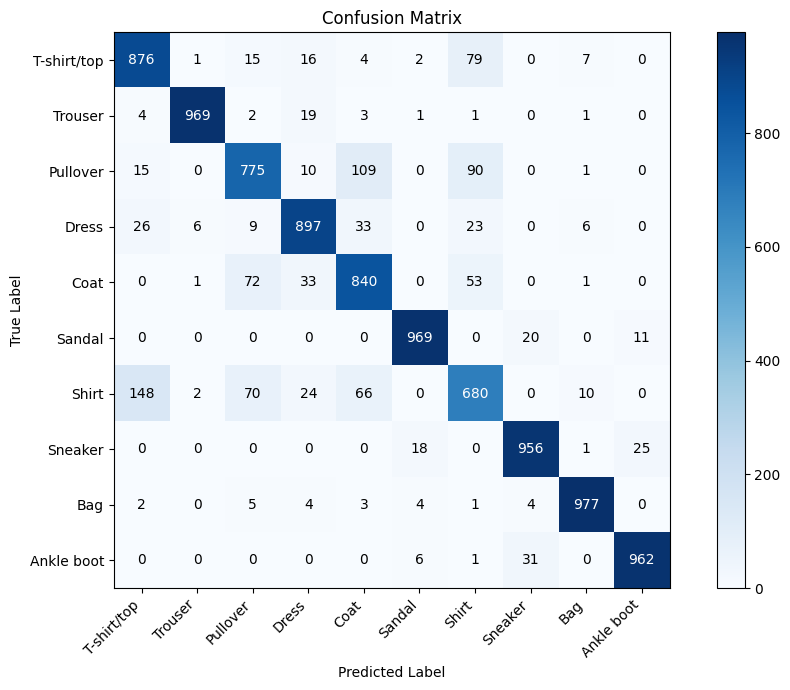

In [34]:
# generated with chatGPT

confusion_matrix = matrix.cpu().numpy()

# Assuming class_to_idx is available from your dataset
class_to_idx = train_data.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}  # Reverse the mapping to get index-to-class mapping
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]  # Class names in order of indices

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
plt.imshow(confusion_matrix, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

# Add tick marks and labels with class names
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha='right')  # Rotate x-labels for better readability
plt.yticks(tick_marks, class_names)

# Optional: Add numbers to the squares
thresh = confusion_matrix.max() / 2.  # For choosing text color
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

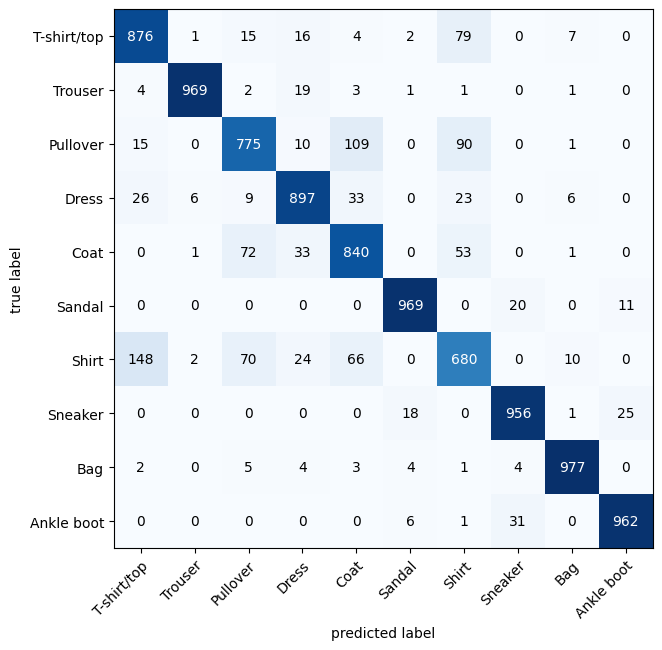

In [35]:
# From the course
fig, ax = plot_confusion_matrix(
    conf_mat=matrix.cpu().numpy(),
    class_names = class_names,
    figsize=(10,7)
)

# 8. Saving model

In [37]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "conv_model_MNIST_FASHION.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

# 9. Loading model

In [39]:
MODEL_PATH = Path("models")
MODEL_NAME = "conv_model_MNIST_FASHION.pth"
MODEL_LOAD_PATH = MODEL_PATH / MODEL_NAME

model = torch.load(MODEL_LOAD_PATH, weights_only=True)
model

OrderedDict([('layers.1.weight',
              tensor([[-0.0040,  0.0273,  0.0250,  ..., -0.0327,  0.0075, -0.0238],
                      [-0.0207, -0.0351, -0.0048,  ...,  0.0029,  0.0009,  0.0299],
                      [-0.0062,  0.0285, -0.0020,  ...,  0.0220,  0.0109,  0.0139],
                      ...,
                      [-0.0265,  0.0205, -0.0011,  ...,  0.0166,  0.0272,  0.0029],
                      [-0.0101,  0.0348,  0.0237,  ..., -0.0098,  0.0067, -0.0130],
                      [ 0.0316, -0.0155, -0.0177,  ...,  0.0100, -0.0191, -0.0302]],
                     device='cuda:0')),
             ('layers.1.bias',
              tensor([-1.4115e-02,  1.0305e-02,  8.7029e-03,  4.9921e-03,  4.9764e-03,
                      -1.3071e-02,  2.4260e-02, -1.5250e-02,  4.2190e-03, -3.2239e-02,
                      -2.3505e-02, -1.4870e-02,  1.3927e-02,  7.2778e-04, -2.8172e-02,
                       1.9877e-02, -3.6006e-03,  2.2847e-02,  3.3314e-02, -1.8940e-02,
                